<h2> Capstone Project Module 3 - Customer Lifetime Value (CLV) </h2> 

**Project Overview**:

**Customer Lifetime Value (CLV)** merupakan salah satu indikator penting dalam strategi pemasaran. CLV dapat digunakan untuk mengidentifikasi pelanggan bernilai tinggi dan membantu perusahaan mengambil keputusan bisnis berbasis data. Dalam proyek ini, digunakan data pelanggan dari perusahaan asuransi untuk membangun model prediksi CLV berdasarkan variabel demografis dan histori klaim pelanggan.

**Tujuan**:
Memprediksi Customer Lifetime Value (CLV) dari data pelanggan asuransi, sekaligus mengidentifikasi faktor-faktor yang paling berpengaruh. Output proyek mencakup model prediktif serta insight bisnis yang dapat diimplementasikan.

**Brief Summary**:
- Dataset terdiri dari 5.669 baris.
- Projek ini bertujuan untuk menganalisis faktor-faktor yang memengaruhi Customer Lifetime Value (CLV).
- Model Terpilih: Gradient Boosting Regressor pada target log(CLV) (dibandingkan dengan Random Forest dan Linear Regression).
- Evaluasi: MAE, RMSE, R², cross-validation stability pada skala log dan asli.
- Interpretasi fitur: Menggunakan Random Forest (hasil tuning) untuk memperoleh insight yang lebih transparan terhadap kontribusi fitur.

**Data Berdasarkan Dimensi dan Kategori**

| Dimensi     | Kategori                                                                 |
|-------------|--------------------------------------------------------------------------|
| Pelanggan   | Employment Status, Marital Status, Education, Income                      |
| Produk      | Vehicle Class, Coverage, Renew Offer Type, Number of Policies            |
| Keuangan    | Monthly Premium Auto, Total Claim Amount, Customer Lifetime Value        |

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from sklearn.inspection import PartialDependenceDisplay
import pickle

<h2> 2. Data Loading and Preview </h2>

In [102]:
# baca data dari file CSV ke dalam DataFrame pandas
df = pd.read_csv("data_customer_lifetime_value.csv")

In [103]:
# preview data 
df.head()

,Vehicle Class,Coverage,Renew Offer Type,EmploymentStatus,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
0,Four-Door Car,Extended,Offer1,Retired,Divorced,High School or Below,2.0,90.0,571.479602,11828.0,10083.486880
1,Four-Door Car,Basic,Offer1,Employed,Married,College,6.0,62.0,114.514440,44762.0,4943.386117
2,Two-Door Car,Basic,Offer1,Retired,Married,Master,2.0,62.0,257.248789,21514.0,11981.984810
3,Four-Door Car,Premium,Offer3,Disabled,Married,High School or Below,1.0,116.0,556.800000,17913.0,4550.856045
4,Two-Door Car,Basic,Offer3,Medical Leave,Married,High School or Below,1.0,62.0,355.820799,19030.0,2372.155492


In [104]:
df.dtypes

Vehicle Class               object
Coverage                    object
Renew Offer Type            object
EmploymentStatus            object
Marital Status              object
Education                   object
Number of Policies         float64
Monthly Premium Auto       float64
Total Claim Amount         float64
Income                     float64
Customer Lifetime Value    float64
dtype: object

<h2> 3. Statistik Deskriptif </h2>

In [105]:
# Statistik Deskriptif
stat_desc = df.describe()
stat_desc

,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
count,5669.000000,5669.000000,5669.000000,5669.000000,5669.000000
mean,2.979361,93.026989,431.407103,37868.188569,8029.874592
std,2.393187,34.551795,287.558038,30490.490723,6916.708246
min,1.000000,61.000000,0.423310,0.000000,1898.007675
25%,1.000000,68.000000,266.932542,0.000000,3954.344534
50%,2.000000,82.000000,379.200000,34322.000000,5800.188903
75%,4.000000,109.000000,549.986128,62464.000000,9031.214859
max,9.000000,297.000000,2759.794354,99934.000000,83325.381190


In [106]:
print(stat_desc)

       Number of Policies  Monthly Premium Auto  Total Claim Amount  \
count         5669.000000           5669.000000         5669.000000   
mean             2.979361             93.026989          431.407103   
std              2.393187             34.551795          287.558038   
min              1.000000             61.000000            0.423310   
25%              1.000000             68.000000          266.932542   
50%              2.000000             82.000000          379.200000   
75%              4.000000            109.000000          549.986128   
max              9.000000            297.000000         2759.794354   

             Income  Customer Lifetime Value  
count   5669.000000              5669.000000  
mean   37868.188569              8029.874592  
std    30490.490723              6916.708246  
min        0.000000              1898.007675  
25%        0.000000              3954.344534  
50%    34322.000000              5800.188903  
75%    62464.000000            

In [107]:
# Statistik Deskriptif - include data kategorikal
df.describe(include="all")

,Vehicle Class,Coverage,Renew Offer Type,EmploymentStatus,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
count,5669,5669,5669,5669,5669,5669,5669.000000,5669.000000,5669.000000,5669.000000,5669.000000
unique,6,3,4,5,3,5,NaN,NaN,NaN,NaN,NaN
top,Four-Door Car,Basic,Offer1,Employed,Married,Bachelor,NaN,NaN,NaN,NaN,NaN
freq,2858,3477,2292,3541,3305,1703,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.979361,93.026989,431.407103,37868.188569,8029.874592
std,NaN,NaN,NaN,NaN,NaN,NaN,2.393187,34.551795,287.558038,30490.490723,6916.708246
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,61.000000,0.423310,0.000000,1898.007675
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,68.000000,266.932542,0.000000,3954.344534
50%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,82.000000,379.200000,34322.000000,5800.188903
75%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,109.000000,549.986128,62464.000000,9031.214859


**Dari hasil statistik deskriptif, didapatkan bahwa**: 
- Terdapat gap yang besar pada variabel pendapatan dan CLV 
- Ditemukan outlier pada CLV dan pendapatan 
- Ada nasabah berpendapatan $0 yang punya polis
- CLV tinggi dimungkinkan berkaitan dengan jumlah polis atau klaim

**Transformasi Log akan digunakan pada variabel target atau CLV**, untuk mengatasi:
- Distribusi asli yang sangat miring (skewness)
- Perbedaan nilai ekstrim (min sebesar $1,898 dan max sebesar $83,325)
- memenuhi ketentuan regresi yakni distribusi normal

<h2> 4. Data Cleaning </h2>

<h3> 4.1 Cek Missing Value </h3>

In [108]:
# cek jumlah data 
df.count()

Vehicle Class              5669
Coverage                   5669
Renew Offer Type           5669
EmploymentStatus           5669
Marital Status             5669
Education                  5669
Number of Policies         5669
Monthly Premium Auto       5669
Total Claim Amount         5669
Income                     5669
Customer Lifetime Value    5669
dtype: int64

In [109]:
# cek missing value
missing_data = df.isnull().sum()
print(missing_data)

Vehicle Class              0
Coverage                   0
Renew Offer Type           0
EmploymentStatus           0
Marital Status             0
Education                  0
Number of Policies         0
Monthly Premium Auto       0
Total Claim Amount         0
Income                     0
Customer Lifetime Value    0
dtype: int64


**Interpretasi Missing Value** : Tidak ada missing value

<h3> 4.2 Pencarian Data Duplikat </h3>

In [110]:
# Cek duplikat penuh (semua kolom)
duplicates = df[df.duplicated(keep=False)]  # Tandai semua duplikat
duplicate_counts = duplicates.groupby(df.columns.tolist()).size().reset_index(name='Count')

print("\nDetail duplikat:")
print(duplicate_counts[duplicate_counts['Count'] > 1])


Detail duplikat:
     Vehicle Class  Coverage Renew Offer Type EmploymentStatus Marital Status  \
0    Four-Door Car     Basic           Offer1         Disabled       Divorced   
1    Four-Door Car     Basic           Offer1         Disabled       Divorced   
2    Four-Door Car     Basic           Offer1         Disabled       Divorced   
3    Four-Door Car     Basic           Offer1         Employed       Divorced   
4    Four-Door Car     Basic           Offer1         Employed       Divorced   
..             ...       ...              ...              ...            ...   
209   Two-Door Car  Extended           Offer2          Retired        Married   
210   Two-Door Car   Premium           Offer1         Employed        Married   
211   Two-Door Car   Premium           Offer1         Employed        Married   
212   Two-Door Car   Premium           Offer1         Employed         Single   
213   Two-Door Car   Premium           Offer2         Employed        Married   

         

In [111]:
# Simpan jumlah baris sebelum penghapusan
jumlah_baris_awal = len(df)

# Penghapusan duplikat
df_clean = df.drop_duplicates(keep='first')

# Jumlah baris setelah penghapusan
jumlah_baris_setelah = len(df_clean)

# Jumlah baris yang dihapus
jumlah_dihapus = jumlah_baris_awal - jumlah_baris_setelah

# Display hasil
print(f"Jumlah baris awal: {jumlah_baris_awal}")
print(f"Jumlah baris setelah penghapusan duplikat: {jumlah_baris_setelah}")
print(f"Jumlah baris yang dihapus: {jumlah_dihapus}")
print(f"Total baris duplikat (unik): {len(duplicate_counts[duplicate_counts['Count'] > 1])}")
print(f"Persentase data dihapus: {jumlah_dihapus/jumlah_baris_awal*100:.2f}%")

Jumlah baris awal: 5669
Jumlah baris setelah penghapusan duplikat: 5051
Jumlah baris yang dihapus: 618
Total baris duplikat (unik): 214
Persentase data dihapus: 10.90%


**Interpretasi**: 

- Data awal terdiri dari 5.669 baris, sebanyak 618 baris (sekitar 10,90%) teridentifikasi sebagai duplikat dan telah dihapus, sehingga tersisa 5.051 baris data unik. hanya 214 di antaranya yang merupakan kombinasi duplikat yang benar-benar unik. 

**Notes**: Data duplikat yang dimaksud dalam data ini yakni yang memiliki nilai yang sama persis di seluruh kolom.

In [112]:
# Baris yang dihapus per kelompok
dihapus_per_kelompok = []

for i, row in duplicate_counts.iterrows():
    if row['Count'] > 1:
        dihapus = row['Count'] - 1
        dihapus_per_kelompok.append(dihapus)
        print(f"Kelompok {i+1}: {row['Count']} baris → Hapus {dihapus}")

Kelompok 1: 4 baris → Hapus 3
Kelompok 2: 5 baris → Hapus 4
Kelompok 3: 5 baris → Hapus 4
Kelompok 4: 4 baris → Hapus 3
Kelompok 5: 4 baris → Hapus 3
Kelompok 6: 5 baris → Hapus 4
Kelompok 7: 4 baris → Hapus 3
Kelompok 8: 3 baris → Hapus 2
Kelompok 9: 3 baris → Hapus 2
Kelompok 10: 5 baris → Hapus 4
Kelompok 11: 4 baris → Hapus 3
Kelompok 12: 4 baris → Hapus 3
Kelompok 13: 2 baris → Hapus 1
Kelompok 14: 5 baris → Hapus 4
Kelompok 15: 4 baris → Hapus 3
Kelompok 16: 5 baris → Hapus 4
Kelompok 17: 5 baris → Hapus 4
Kelompok 18: 5 baris → Hapus 4
Kelompok 19: 2 baris → Hapus 1
Kelompok 20: 4 baris → Hapus 3
Kelompok 21: 5 baris → Hapus 4
Kelompok 22: 5 baris → Hapus 4
Kelompok 23: 4 baris → Hapus 3
Kelompok 24: 3 baris → Hapus 2
Kelompok 25: 4 baris → Hapus 3
Kelompok 26: 2 baris → Hapus 1
Kelompok 27: 2 baris → Hapus 1
Kelompok 28: 5 baris → Hapus 4
Kelompok 29: 3 baris → Hapus 2
Kelompok 30: 5 baris → Hapus 4
Kelompok 31: 2 baris → Hapus 1
Kelompok 32: 5 baris → Hapus 4
Kelompok 33: 3 ba

<h2> 5. Exploratory Data Analysis </h2>

<h3> 5.1 Visualisasi Distribusi CLV Original dan Versi Log  </h3>

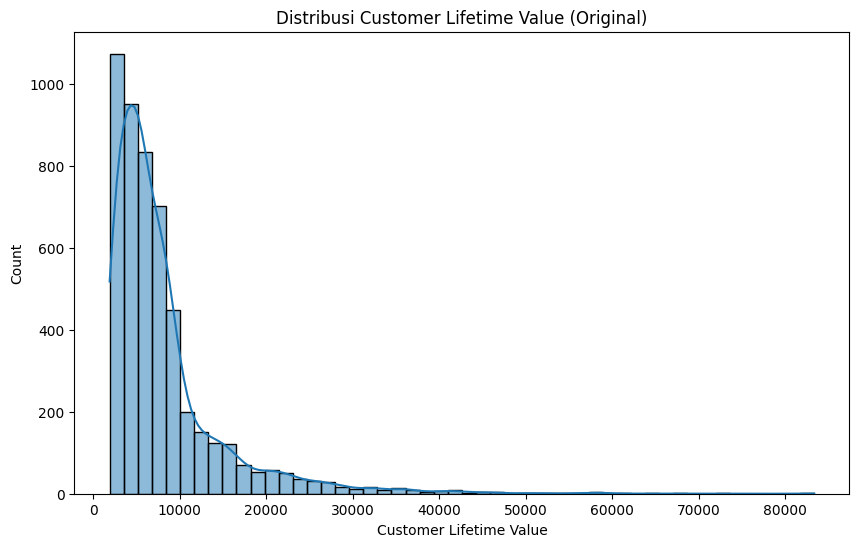

In [113]:
# Analisis Distribusi CLV Original 
plt.figure(figsize=(10,6))
sns.histplot(df_clean['Customer Lifetime Value'], bins=50, kde=True)
plt.title('Distribusi Customer Lifetime Value (Original)')
plt.show()

**Interpretasi Distribusi CLV original**:
- Distribusi sangat skewed ke kanan (right-skewed), terlihat dari ekor distribusi yang memanjang ke arah nilai CLV tinggi.
- Mayoritas data terkonsentrasi pada rentang $0–$20.000, dengan puncak (modus) berada di sekitar $4.000–$6.000.

**Masalah Statistik:**
- Terdapat outlier ekstrem, yaitu nilai-nilai CLV yang melebihi $60.000, bahkan mencapai sekitar $83.000.
- Terjadi ketimpangan besar antara nilai min dan max.
- Distribusi yang tidak normal, yang tidak memenuhi asumsi model regresi linear tradisional.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15208\1424196994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['CLV_log'] = np.log1p(df_clean['Customer Lifetime Value'])


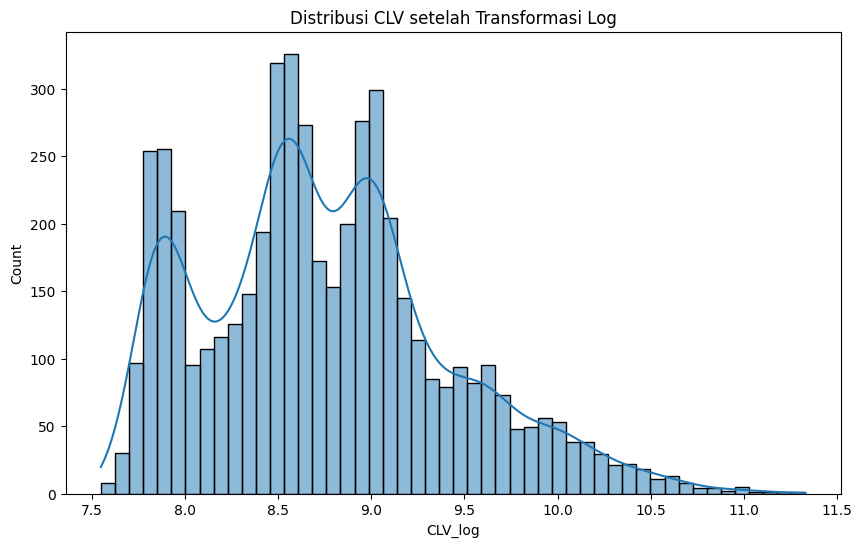

In [114]:
# Transformasi log 
df_clean['CLV_log'] = np.log1p(df_clean['Customer Lifetime Value'])

# Analisis Distribusi CLV Log
plt.figure(figsize=(10,6))
sns.histplot(df_clean['CLV_log'], bins=50, kde=True)
plt.title('Distribusi CLV setelah Transformasi Log')
plt.show()

**Interpretasi Distribusi Data CLV Log**: 

**Transformasi ini membantu mengurangi pengaruh outlier dan ketimpangan yang sebelumnya sangat terlihat pada data CLV original.**
- Setelah transformasi log, distribusi CLV lebih mendekati distribusi normal, meskipun masih sedikit right-skewed.
- Varians menjadi stabil dan sebaran data menjadi lebih homogen, dimana cocok untuk regresi.
- Mayoritas nilai CLV log terkonsentrasi di 8.0 hingga 9.2, dengan peak berada di kisaran 8.5–8.8.

<h3> 5.2 Visualisasi Analisis Outlier </h3>

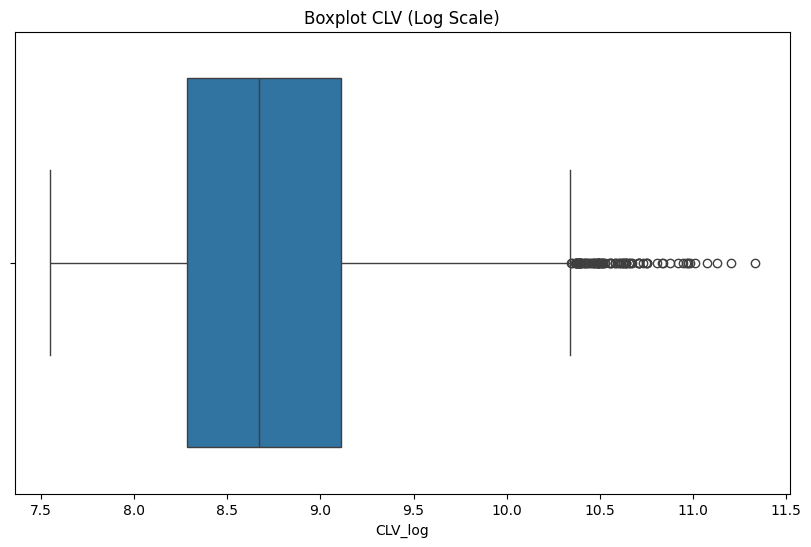

In [115]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df_clean['CLV_log'])
plt.title('Boxplot CLV (Log Scale)')
plt.show()

**Interpretasi Boxplot**: 
- Distribusi CLV (log) masih tidak sepenuhnya simetris, dengan adanya positive skewness, ditandai oleh banyaknya outlier di sisi kanan (nilai tinggi).
- Median berada condong ke kiri, menunjukkan bahwa data cenderung terkonsentrasi pada nilai yang lebih rendah.
- Terlihat banyak outlier di rentang sekitar 10.5 hingga 11.5.
- Meskipun transformasi log berhasil mengurangi ketimpangan ekstrim, beberapa nilai tinggi tetap dianggap outlier secara statistik.

<h3> 5.3 Korelasi & Analisis Multivariat </h3>

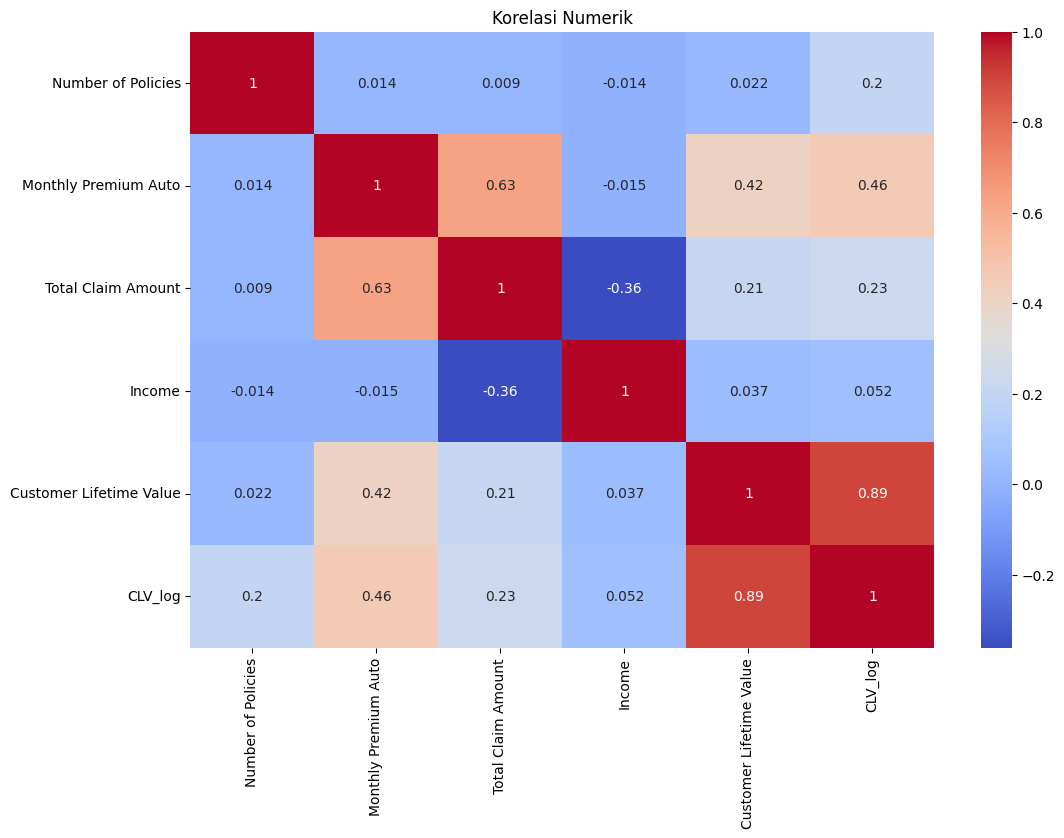

In [116]:
plt.figure(figsize=(12,8))
sns.heatmap(df_clean.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Korelasi Numerik')
plt.show()

**Interpretasi Korelasi**: 

**1. Premi dan Klaim Berkaitan Erat**:
Korelasi positif moderat (0.63) antara Monthly Premium Auto dan Total Claim Amount menunjukkan bahwa perusahaan mungkin menyesuaikan premi berdasarkan riwayat klaim pelanggan.

**2. Nilai Pelanggan Dipengaruhi Premi**:
Monthly Premium Auto berkorelasi positif dengan CLV dan CLV_log (0.42 dan 0.46). Artinya, pelanggan yang membayar premi tinggi cenderung lebih menguntungkan dalam jangka panjang.

**3. Pengaruh Pendapatan**:
Pelanggan berpenghasilan tinggi (Income) cenderung memiliki klaim lebih kecil (-0.36), tetapi tidak memengaruhi kepemilikan polis.

**4. Transformasi Logaritmik CLV Valid**:
Korelasi sangat tinggi antara CLV dan CLV_log (0.89) membuktikan bahwa transformasi logaritmik tidak mengubah pola hubungan antar variabel—hanya membuat distribusi data lebih stabil.

<h3> 5.4 Skewness </h3>

In [117]:
# Define Dataframe yang sudah dibersihkan menjadi df
df = df_clean.copy()

# Kolom target (Customer Lifetime Value)
target_col = 'Customer Lifetime Value'

# Cek skewness sebelum transformasi
print("Skewness CLV sebelum transformasi:")
print(df[target_col].skew())

# Transformasi log pada CLV saja
df[target_col] = np.log1p(df[target_col])

# Cek skewness setelah transformasi
print("\nSkewness CLV setelah transformasi:")
print(df[target_col].skew())

Skewness CLV sebelum transformasi:
3.1140158566597465

Skewness CLV setelah transformasi:
0.5679706530915477


**Interpretasi Skewness Setelah dan Sebelum Transformasi**:

- Sebelum transformasi menunjukkan distribusi nilai CLV sangat menceng ke kanan (right-skewed), terdapat outlier dan nilai ekstrim.

- Setelah transformasi log membuat distribusi menjadi jauh lebih simetris.Skewness < 0.5–0.6 mendekati normal untuk keperluan modeling, yang menandakan transformasi berhasil mengurangi ketimpangan distribusi.

<h2> 6. Data dan Pemodelan Regresi </h2>

**Pemilihan Keputusan: Setelah mengeksplorasi CLV original dan log, menunjukkan bahwa transformasi log perlu diterapkan pada variabel target (CLV) agar mendapatkan hasil yang lebih stabil.**     

**Notes**: df_clean sudah di define sebagai df pada bagian skewness

In [118]:
# Target CLV_log (log-transform)
df['CLV_log'] = np.log1p(df['Customer Lifetime Value']) # melakukan transformasi log pada variabel target atau CLV

# Pisahkan fitur dan target 
X = df.drop(columns=['Customer Lifetime Value', 'CLV_log'])
y = df['CLV_log'] # ini variabel targetnya

# Pembagian data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1042)

# Encoding variabel kategorikal
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ])

<h2> 7. Evaluasi Model </h2>

In [ ]:
# Model untuk evaluasi
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=2042, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=2042)
    
}

# Evaluasi model
results = {}
for name, model in models.items():
    # Buat pipeline untuk setiap model
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    
    # Hitung metrik evaluasi
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}
    
# Tampilkan hasil evaluasi
results_df = pd.DataFrame(results).T
print("\nHasil Evaluasi Model:")
print(results_df)


Hasil Evaluasi Model:
                        MAE       MSE      RMSE        R2
Linear Regression  0.043097  0.003093  0.055618  0.278853
Random Forest      0.010142  0.000445  0.021099  0.896216
Gradient Boosting  0.010310  0.000387  0.019680  0.909713


<Figure size 1200x600 with 0 Axes>

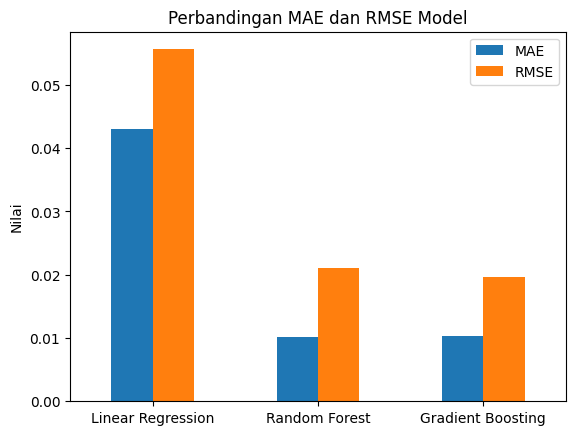

In [120]:
# Visualisasi hasil evaluasi
plt.figure(figsize=(12, 6))
results_df[['MAE', 'RMSE']].plot(kind='bar', rot=0)
plt.title('Perbandingan MAE dan RMSE Model')
plt.ylabel('Nilai')
plt.show()

**Interpretasi Evaluasi Model**: 
- Linear Regression kurang cocok digunakkan pada dataset ini karena MAE dan RMSE yang lebih tinggi serta nilai R² yang rendah (0.28). Dimana, menunjukkan bahwa model kurang mampu menjelaskan variasi data target. 
- Random Forest dan Gradient Boosting menunjukkan performa yang jauh lebih baik, dengan nilai MAE dan RMSE yang lebih rendah serta R² yang tinggi dengan nilai 0.89 dan 0.90.
- Gradient Boosting memberikan hasil terbaik secara keseluruhan yang paling akurat dalam memprediksi CLV, dengan MAE yang kecil sebesar 0.103, RMSE yang kecil sebesar 0.200, dan R² tertinggi dengan nilai 0.90.

<h2> 8. Cross-Validation </h2>

In [121]:
# Cross-validation untuk evaluasi lebih robust
cv_results = {}
for name, model in models.items():
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Gunakan neg_mean_squared_error untuk cross validation
    mse_scores = -cross_val_score(
        model_pipeline, X_train, y_train,
        cv=5, scoring='neg_mean_squared_error'
    )
    rmse_scores = np.sqrt(mse_scores)
    
    cv_results[name] = {
        'Mean RMSE': rmse_scores.mean(),
        'Std RMSE': rmse_scores.std()
    }
print("\nHasil Cross-Validation:")
cv_df = pd.DataFrame(cv_results).T
print(cv_df)


Hasil Cross-Validation:
                   Mean RMSE  Std RMSE
Linear Regression   0.056981  0.000721
Random Forest       0.020350  0.000416
Gradient Boosting   0.019655  0.000226


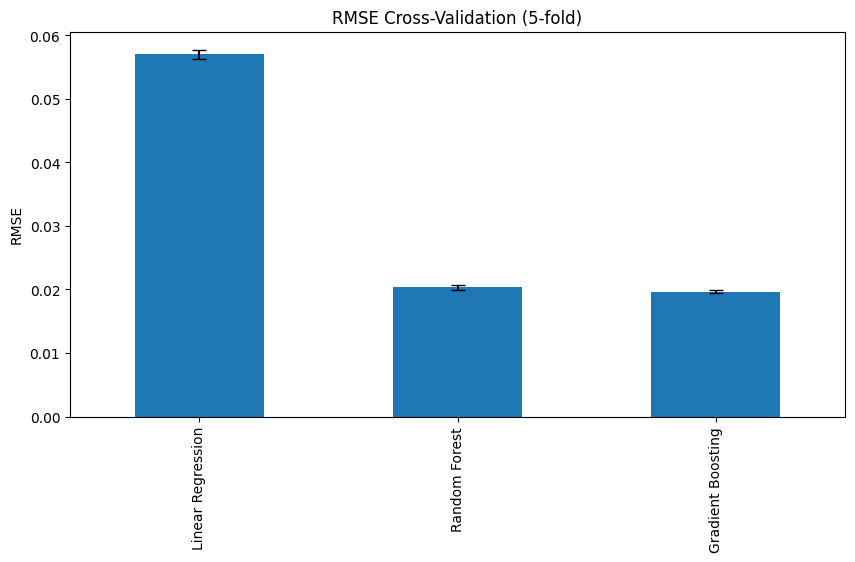

In [122]:
# Visualisasi hasil cross-validation
plt.figure(figsize=(10, 5))
cv_df['Mean RMSE'].plot(kind='bar', yerr=cv_df['Std RMSE'], capsize=5)
plt.title('RMSE Cross-Validation (5-fold)')
plt.ylabel('RMSE')
plt.show()

**Interpretasi Cross-Validation**:

- Gradient Boosting memberikan performa terbaik, dengan RMSE terendah sebesar 0.0197 dan variasi antar fold paling kecil (Std RMSE: 0.0002). Hal ini menunjukkan bahwa model ini paling akurat dan konsisten dalam melakukan prediksi log(CLV).
- Random Forest juga menunjukkan performa yang sangat baik, dengan RMSE sebesar 0.0204 dan variasi antar fold yang masih rendah (Std RMSE: 0.0004), sedikit di atas Gradient Boosting.
- Linear Regression memiliki performa paling rendah, dengan RMSE tertinggi sebesar 0.0570 dan variasi antar fold lebih besar (Std RMSE: 0.0007). Ini menandakan bahwa model linear kurang cocok digunakan untuk dataset ini karena tidak mampu menangkap pola kompleks yang ada.

<h2> 9. Hyperparameter Tuning </h2>

In [123]:
param_grid = {
    'regressor__n_estimators': [100, 200, 300], # Menambahkan 300
    'regressor__max_depth': [None, 10, 20, 30], # Menambahkan 30
    'regressor__min_samples_split': [2, 5, 10], # Menambahkan 10
    'regressor__min_samples_leaf': [1, 2, 4]    # Menambahkan min_samples_leaf
}

# Inisialisasi GridSearchCV dengan pipeline
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='r2',
    verbose=1
)

# verbose=1 akan menampilkan progres
print("Memulai proses GridSearchCV. Proses load butuh waktu...")
grid_search.fit(X_train, y_train)

# Display Best Parameter
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best R2 Score (on training data with cross-validation): {grid_search.best_score_:.2f}")

# Model terbaik dari GridSearch
best_rf_model = grid_search.best_estimator_

# Prediksi pada Test Set menggunakan model terbaik
y_pred_tuned = best_rf_model.predict(X_test)

# Evaluasi model terbaik pada Test Set
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)

print(f"Mean Absolute Error (MAE) with Tuned Model on Test Set: {mae_tuned:.2f}")
print(f"Mean Squared Error (MSE) with Tuned Model on Test Set: {mse_tuned:.2f}")
print(f"Root Mean Squared Error (RMSE) with Tuned Model on Test Set: {rmse_tuned:.2f}")
print(f"R2 Score with Tuned Model on Test Set: {r2_tuned:.2f}")

Memulai proses GridSearchCV. Proses load butuh waktu...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best R2 Score (on training data with cross-validation): 0.90
Mean Absolute Error (MAE) with Tuned Model on Test Set: 0.01
Mean Squared Error (MSE) with Tuned Model on Test Set: 0.00
Root Mean Squared Error (RMSE) with Tuned Model on Test Set: 0.02
R2 Score with Tuned Model on Test Set: 0.88


**Interpretasi Tuning**: 

Gradient Boosting masih menjadi model terbaik, bahkan setelah Random Forest dituning. Ditunjukkan dari R2 Gradient Boosting nya yang lebih besar.

<h2> 10. Feature Importance </h2>

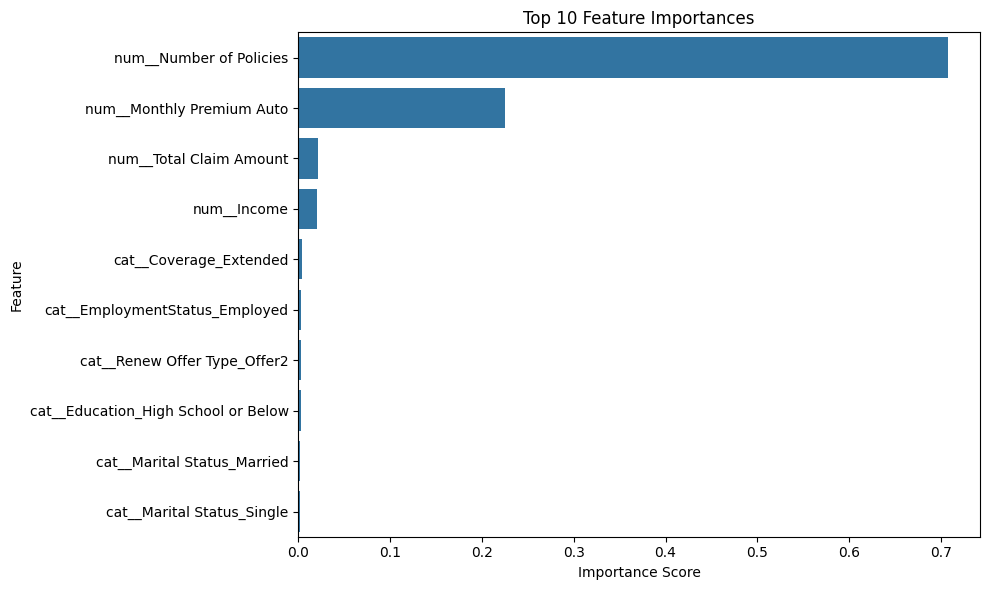

In [124]:
# Model dan preprocessing pipeline
rf_model = best_rf_model.named_steps['regressor']
preprocessor = best_rf_model.named_steps['preprocessor']

# Ambil nama fitur numerik dan kategorikal
num_features = preprocessor.transformers_[0][2]  # kolom numerik

# Untuk OneHotEncoder (langsung, bukan pipeline)
cat_encoder = preprocessor.transformers_[1][1]
cat_columns = preprocessor.transformers_[1][2]
cat_features = cat_encoder.get_feature_names_out(cat_columns)

# Gabungkan nama fitur akhir
all_feature_names = (
    [f"num__{feat}" for feat in num_features] +
    [f"cat__{feat}" for feat in cat_features]
)

# Define feature importances
importances = rf_model.feature_importances_

# Dataframe dan visualisasikan
feat_imp_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

**Interpretasi Feature Importance**:

**Notes**: Meskipun model terbaik adalah Gradient Boosting, analisis feature importance menggunakan model Random Forest hasil tuning karena model memberikan interpretasi fitur yang lebih stabil.

- Model sangat bergantung pada fitur numerik operasional, dimana pengaruh terbesar dari Number of Policies dan Monthly Premium Auto. **Dalam artian semakin banyak polis yang dimiliki pelanggan dan pembayaran bulanan yang diberikan, semakin besar potensi nilai yang di hasilkan bagi perusahaan dalam jangka panjang**.
- Fitur kategorikal memiliki kontribusi minimal terhadap prediksi.

<h2> 11. Cek Data Leakage </h2>

<h3> 11.1 Partial Dependence Plot (PDP) </h3>

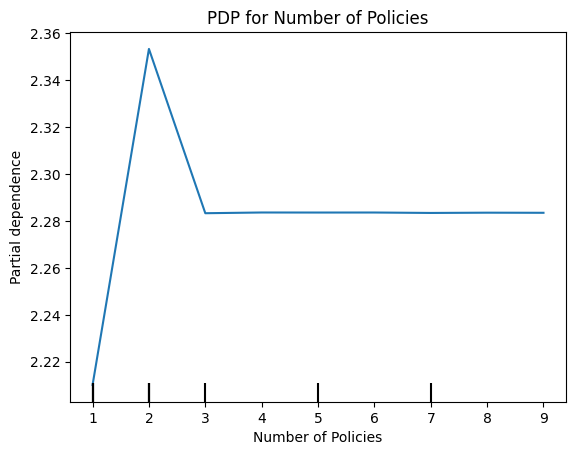

In [125]:
feature_to_plot = 'Number of Policies'  # Nama kolom asli di data mentah

PartialDependenceDisplay.from_estimator(
    best_rf_model, 
    X_train,  # Data training asli (DataFrame dengan kolom original)
    features=[feature_to_plot],
    feature_names=X_train.columns.tolist(),  # Nama kolom asli
    grid_resolution=20
)

plt.title(f'PDP for {feature_to_plot}')
plt.show()

**Interpretasi PDP**: **Terkonfirmasi bahwa tidak ada data leakage**

nilai partial dependence meningkat tajam dari 1 ke 2 policy, menunjukkan bahwa pelanggan dengan 2 polis memiliki pengaruh positif yang besar terhadap target. Namun setelah itu, pengaruhnya menurun dan menjadi stabil mulai dari 3 polis ke atas. Pola ini menunjukkan bahwa model tidak terlalu sensitif terhadap nilai yang lebih tinggi dan tidak ada fluktuasi yang anomali. Oleh karena itu, tidak ditemukan indikasi data leakage.

<h3> 11.2 Cross-Validation Stability </h3>

In [126]:
scoring_metric = 'neg_mean_squared_error'  

cv_scores = cross_val_score(
    best_rf_model,
    X_train, 
    y_train,
    cv=5,
    scoring=scoring_metric
)

print("\nCross-Validation Stability")
print(f"Skor per fold: {[f'{s:.4f}' for s in cv_scores]}")
print(f"Rata-rata: {np.mean(cv_scores):.4f}")
print(f"Standar Deviasi: {np.std(cv_scores):.4f}")


Cross-Validation Stability
Skor per fold: ['-0.0004', '-0.0005', '-0.0004', '-0.0005', '-0.0005']
Rata-rata: -0.0005
Standar Deviasi: 0.0000


**Interpretasi Cross-Validation Stability**

Model menunjukkan performa yang sangat stabil dan konsisten, dengan rata-rata kesalahan (MSE) sebesar 0.0005 dan deviasi antar fold yang sangat kecil (mendekati 0.0000). Hal ini mengindikasikan bahwa model tidak sensitif terhadap pembagian data dalam cross-validation dan memiliki kemampuan generalisasi yang sangat baik terhadap data baru.

<h2> 12. Finalisasi Model dan Evaluasi Akhir (Gradient Boosting) </h2>

In [127]:
# Pipeline final dengan Gradient Boosting
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=2042))
])

# Fit ulang dengan seluruh data training
final_model.fit(X_train, y_train)

# Simpan model
with open('gradient_boosting_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

# Evaluasi akhir
y_pred_final = final_model.predict(X_test)
r2_final = r2_score(y_test, y_pred_final)
rmse_final = root_mean_squared_error(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)

print("Model Final: Gradient Boosting")
print(f"R2 Score: {r2_final:.3f}")
print(f"RMSE: {rmse_final:.3f}")
print(f"MAE: {mae_final:.3f}")

Model Final: Gradient Boosting
R2 Score: 0.910
RMSE: 0.020
MAE: 0.010


**Interpretasi Final dengan Model Gradient Boosting**: 
Model dapat menjelaskan 91% variasi pada Customer Lifetime Value, dengan rata-rata kesalahan prediksi yang sangat kecil.

In [128]:
# Evaluasi Train & Test
y_train_pred = final_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
y_test_pred = final_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train R2 Score: {r2_train:.3f}")
print(f"Test R2 Score: {r2_test:.3f}")
print(f"Selisih: {abs(r2_train - r2_test):.3f}")

Train R2 Score: 0.925
Test R2 Score: 0.910
Selisih: 0.015


**Interpretasi Evaluasi Train & Test**: Evaluasi Train dan Test R² secara eksplisit hanya dilakukan pada model Gradient Boosting karena model ini menunjukkan performa terbaik dan paling stabil. Selisih R² antara data train (0.925) dan data test (0.910) hanya 0.015, menandakan model memiliki generalisasi yang sangat baik dan tidak overfitting.


<h2> Kesimpulan dan Rekomendasi </h2>

**Kesimpulan**:
- Model terbaik berdasarkan RMSE dan R² adalah **Gradient Boosting Regressor**. 
- Model ini menunjukkan akurasi prediksi yang tinggi dan performa generalisasi yang baik pada data test.
- Dengan performa yang bagus, dengan seluruh pengecekan menunjukkan tidak ada data leakage atau overfitting.
- Namun, untuk interpretasi fitur menggunakan **Random Forest** karena lebih transparan dan stabil.

**Rekomendasi**:
- Model ini dapat digunakan untuk membantu tim pemasaran dan retensi dalam mengidentifikasi pelanggan dengan nilai CLV tinggi.
- Lakukan pelatihan ulang model secara berkala untuk mengikuti perubahan data pelanggan.
- Untuk segmen pelanggan bernilai sangat tinggi, akurasi masih bisa ditingkatkan dengan eksplorasi fitur tambahan.

**Limitasi Model**:
- Model bekerja optimal pada pola data yang serupa dengan data historis.
- Model tidak mempertimbangkan variabel waktu atau perubahan musiman (non-time series).
- Fitur yang digunakan terbatas pada data demografis dan transaksi dasar.

<h2> Insight Bisnis </h2>

- Pelanggan dengan jumlah polis lebih banyak dan premi bulanan lebih tinggi cenderung memiliki nilai CLV yang tinggi. Ini membuka peluang untuk strategi upselling ke pelanggan yang saat ini hanya memiliki 1 produk.

- Karena faktor demografis tidak terlalu berpengaruh, pendekatan personalisasi sebaiknya difokuskan pada riwayat produk dan transaksi, bukan semata pada usia, status menikah, atau pendidikan.

- Pelanggan dengan CLV tinggi bisa menjadi target utama program loyalitas dan retensi, sementara pelanggan dengan nilai rendah tapi potensi tinggi (misalnya premi rendah tapi stabil) bisa disasar untuk cross-selling.
